# Differentiation using Heterogeneous Synapses

The following model shows how to solve for the decoders over time to compute functions that depend on past inputs (i.e. a filter). To do this accurately in some cases, without principle 3, it becomes necessary to introduce heterogeneous synapses, so that each neuron's "augmented encoder" will extract different "temporal features" from the input.

In [4]:
%pylab inline
import pylab
try:
    import seaborn as sns  # optional; prettier graphs
except ImportError:
    pass

import numpy as np
import nengo
import nengolib


def make_model(synapses, encoders, decoders, n_neurons, tau_derivative,
               seed, stim_seed, dt, T, stim_cutoff_freq=15, stim_rms=0.5,
               neuron_type=nengo.LIF()):

    with nengolib.Network(seed=seed) as model:

        # White noise input
        stim = nengo.Node(output=nengo.processes.WhiteSignal(
            T, high=stim_cutoff_freq, rms=stim_rms, seed=stim_seed))

        # Heterogeneous synapses (one per neuron)
        x_synapses = nengo.Node(
            size_in=1, output=nengolib.HeteroSynapse(synapses, dt=dt))

        # Ensemble that encodes the signal
        x = nengo.Ensemble(
            n_neurons, 1, encoders=encoders, neuron_type=neuron_type)
        
        # Optional decoding (linear readout)
        if decoders is None:
            decoders = np.zeros((n_neurons, 1))
        y = nengo.Node(size_in=1)

        # Connections
        nengo.Connection(stim, x_synapses, synapse=None)
        nengo.Connection(x_synapses, x.neurons,
                         function=lambda x: x*encoders[:, 0], synapse=None)
        nengo.Connection(x.neurons, y, transform=decoders.T,
                         synapse=tau_derivative)

        # Probes
        p_input = nengo.Probe(stim, synapse=None)
        #p_synapses = nengo.Probe(x_synapses, synapse=tau_derivative)
        p_x = nengo.Probe(x.neurons, synapse=tau_derivative)
        p_y = nengo.Probe(y, synapse=None)

        return model, (p_input, p_x, p_y)

Populating the interactive namespace from numpy and matplotlib
2.1.0-dev


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
n_neurons = 1000
tau_derivative = 0.005

seed = 0
rng = np.random.RandomState(seed)

taus = rng.uniform(0.0005, 0.01, size=n_neurons)  # encoding filters
synapses = [nengolib.Lowpass(tau) for tau in taus]
encoders = nengolib.stats.sphere.sample(n_neurons, rng=rng)

We will approximate the filter $H(s) = 2\tau s / (\tau s + 1)$. This is the derivative $s$ multiplied by a lowpass $1 / (\tau s + 1)$ (to make it causal) and scaled by $2\tau$ (for normalization).

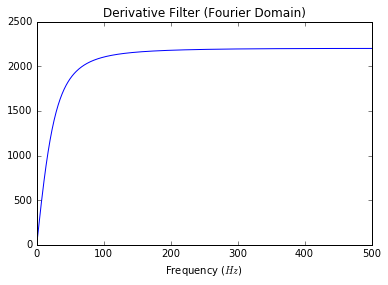

In [6]:
H = 2 * nengolib.synapses.Highpass(tau_derivative)

h_size = 1000
h_dt = 0.001
freqs = np.fft.rfftfreq(h_size, d=h_dt)
desired = nengolib.signal.impulse(H, h_dt, h_size)

pylab.figure()
pylab.title("Derivative Filter (Fourier Domain)")
pylab.plot(freqs, abs(np.fft.rfft(desired)), label="Desired")
pylab.xlabel("Frequency ($Hz$)")
#pylab.legend(loc='center right')
pylab.show()

### Training

To solve for the decoders, we first simulate the network on a $15\,Hz$ training signal and collect the spike data filtered by $\tau$. Then use a decoder solver (e.g. LstsqL2) where the target points are $y = (x \ast h)(t)$ given the filtered spikes $x$.

In [7]:
dt = 0.0002
T = 1.0

model, (p_input, p_x, p_y) = make_model(
    synapses, encoders, decoders=None, n_neurons=n_neurons,
    tau_derivative=tau_derivative, seed=seed, stim_seed=0, dt=dt, T=T)
sim = nengo.Simulator(model, dt=dt)
sim.run(T, progress_bar=False)

/Users/celiasmi/Library/Python/2.7/lib/python/site-packages/nengolib/signal/system.py:220: UserWarning: Synapse (([ 2. -2.], [ 1.         -0.96078944], False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938)
  "(https://github.com/nengo/nengo/issues/938)" % sys)


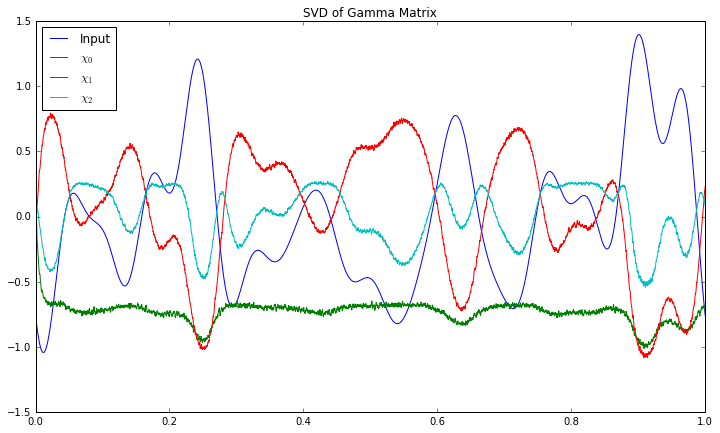

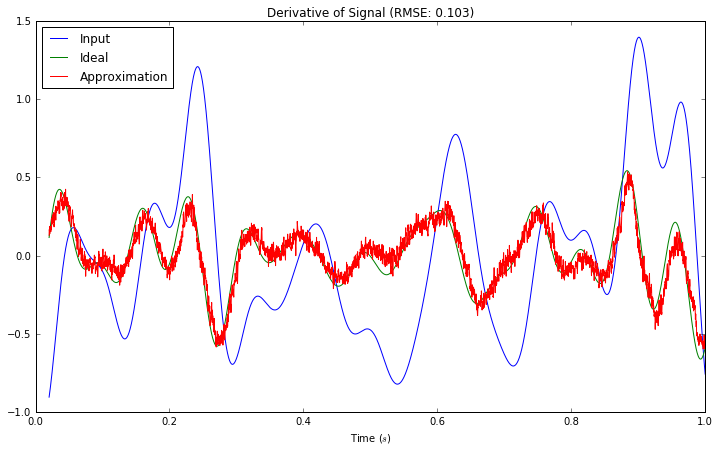

In [8]:
# AD = Y
X = sim.data[p_input]
A = sim.data[p_x]
Y = H.filt(X, dt=dt)
decoders, info = nengo.solvers.LstsqL2()(A, Y)
Y_hat = np.dot(A, decoders)


gamma = np.dot(A.T, A)
U, S, V = np.linalg.svd(gamma)
chi = np.dot(A, U)
pylab.figure(figsize=(12, 7))
pylab.title("SVD of Gamma Matrix")
pylab.plot(sim.trange(), X, label="Input")
for i in range(3):
    pylab.plot(sim.trange(), chi[:, i] / len(chi), label=r"$\chi_%d$" % i)
pylab.legend(loc='best')
pylab.show()


def plot_signals(X, Y, Y_hat, offset=100):
    pylab.figure(figsize=(12, 7))
    pylab.title("Derivative of Signal (RMSE: %.3f)" % nengo.utils.numpy.rmse(Y, Y_hat))    
    pylab.plot(sim.trange()[offset:], X[offset:], label="Input")
    pylab.plot(sim.trange()[offset:], Y[offset:], label="Ideal")
    pylab.plot(sim.trange()[offset:], Y_hat[offset:], label="Approximation")
    pylab.legend(loc='best')
    pylab.xlabel("Time ($s$)")
    #pylab.ylim(-1, 1)
    pylab.show()
    
plot_signals(X, Y, Y_hat)

### Validation

Now we demonstrate that these same decoders generalize to other signals, even at a different frequency (e.g. $10\,Hz$)!

In [9]:
model, (p_input, p_x, p_y) = make_model(
    synapses, encoders, decoders=decoders, n_neurons=n_neurons,
    tau_derivative=tau_derivative, seed=seed, stim_seed=1, dt=dt, T=T,
    stim_cutoff_freq=10)
sim = nengo.Simulator(model, dt=dt)
sim.run(T, progress_bar=False)

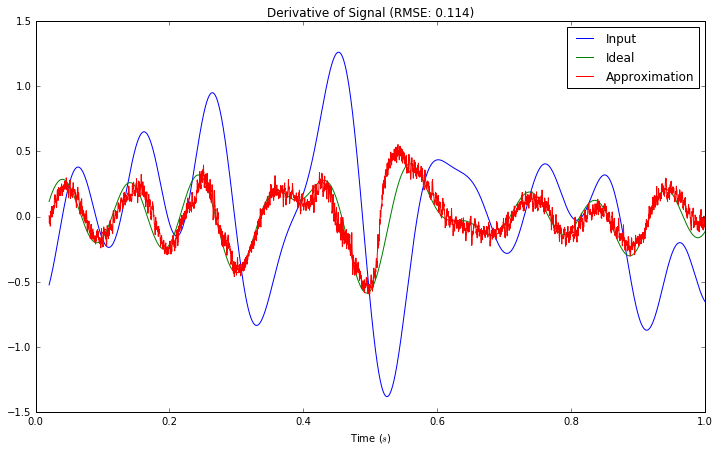

In [10]:
X = sim.data[p_input]
Y = nengolib.signal.apply_filter(H, dt, X, axis=0)
Y_hat = sim.data[p_y]

plot_signals(X, Y, Y_hat)

Lastly it is natural to wonder how crucial it is to have heterogeneous synapses. We can answer that question by repeating this with a number of different sampling widths, i.e. $\tau \sim \mathcal{U}[L, L + width]$ for various $width$ parameters.

In [17]:
num_samples = 10
plot_x = []
plot_y = []
T = 1

for width in np.linspace(0, 0.01, num_samples):
    L, U = 0.0002, 0.0002 + width

    rng = np.random.RandomState(seed)
    taus = rng.uniform(L, U, size=n_neurons)
    synapses = [nengolib.Lowpass(tau) for tau in taus]

    model, (p_input, p_x, p_y) = make_model(
        synapses, encoders, decoders=None, n_neurons=n_neurons,
        tau_derivative=tau_derivative, seed=seed, stim_seed=0, dt=dt, T=T)
    sim = nengo.Simulator(model, dt=dt)
    sim.run(T, progress_bar=False)

    X = sim.data[p_input]
    A = sim.data[p_x]
    Y = H.filt(X, dt=dt)
    decoders, info = nengo.solvers.LstsqL2()(A, Y)
    Y_hat = np.dot(A, decoders)

    plot_x.append(width)
    plot_y.append(nengo.utils.numpy.rmse(Y, Y_hat))

In [18]:
from scipy.optimize import curve_fit

def fit(x, a, b, c, d, e):
    return a*np.exp(-b*x) + c*np.exp(-d*x) + e

popt, pcov = curve_fit(fit, plot_x, plot_y, bounds=(0, [1., 10000., 1., 10000., 1.]))

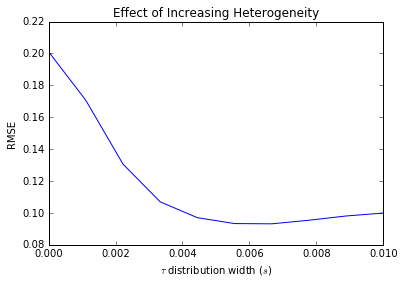

In [21]:
pylab.figure()
pylab.title("Effect of Increasing Heterogeneity")
pylab.plot(plot_x, plot_y)
#pylab.plot(plot_x, fit(np.asarray(plot_x), *popt), color='green', linewidth=1, alpha=0.8)
pylab.xlabel(r"$\tau$ distribution width ($s$)")
pylab.ylabel("RMSE")
pylab.show()